In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from easydict import EasyDict
import os

import warnings
from tqdm import tqdm

# Disable all warnings
warnings.filterwarnings('ignore')
from pcdet.utils import box_utils, common_utils

os.chdir("../")

### AVLRooftop dataset

In [4]:
def get_AVLRooftopDataset():
    from pcdet.datasets.avlrooftop.avlrooftop_dataset import AVLRooftopDataset
    cfg_path =  "cfgs/dataset_configs/avlrooftop/OD/avlrooftop_dataset.yaml"
    dataset_cfg = EasyDict(yaml.safe_load(open(cfg_path)))

    dataset_class_names = ["Vehicle_Drivable_Car",
                    "Vehicle_Drivable_Van",
                    "LargeVehicle_Truck",
                    "LargeVehicle_TruckCab",
                    "LargeVehicle_Bus",
                    "LargeVehicle_Bus_Bendy",
                    "Trailer",
                    "Vehicle_Ridable_Motorcycle",
                    "Vehicle_Ridable_Bicycle",
                    "Human",
                    "PPObject_Stroller"]

    return AVLRooftopDataset(dataset_cfg=dataset_cfg, class_names=dataset_class_names, training=False)
dataset = get_AVLRooftopDataset()

### AVLTruck

In [5]:
def get_AVLTruckDataset():
    from pcdet.datasets.avltruck.avltruck_dataset import AVLTruckDataset
    cfg_path =  "cfgs/dataset_configs/avltruck/OD/avltruck_dataset.yaml"
    dataset_cfg = EasyDict(yaml.safe_load(open(cfg_path)))

    dataset_class_names = ['Vehicle_Drivable_Car',
                    'Vehicle_Drivable_Van', 
                    'Vehicle_Ridable_Motorcycle', 
                    'Vehicle_Ridable_Bicycle', 
                    'Human', 
                    'LargeVehicle_Bus', 
                    'LargeVehicle_TruckCab', 
                    'LargeVehicle_Truck', 
                    'Trailer']

    return AVLTruckDataset(dataset_cfg=dataset_cfg, class_names=dataset_class_names, training=False)
dataset = get_AVLTruckDataset()

### ZOD

In [6]:
def get_ZOD_dataset():
    from pcdet.datasets.zod.zod_dataset import ZODDataset
    cfg_path =  "cfgs/dataset_configs/zod/OD/zod_dataset.yaml"
    dataset_cfg = EasyDict(yaml.safe_load(open(cfg_path)))

    dataset_class_names = ["Vehicle_Car", 
                    "Vehicle_Van", 
                    "Vehicle_Truck", 
                    "Vehicle_Trailer", 
                    "Vehicle_Bus", 
                    "Vehicle_HeavyEquip", 
                    "Vehicle_TramTrain",
                    "VulnerableVehicle_Bicycle",
                    "VulnerableVehicle_Motorcycle",
                    "Pedestrian"]

    return ZODDataset(dataset_cfg=dataset_cfg, class_names=dataset_class_names, training=False)

dataset = get_ZOD_dataset()

Loading infos: 0it [00:00, ?it/s]

In [9]:
def keep_info_with_names(info, names):
    if isinstance(names, str):
        names = [names]
    ret_info = {}
    keep_indices = [i for i, x in enumerate(info['name']) if x in names]
    for key in info.keys():
        ret_info[key] = info[key][keep_indices]
    return ret_info

def get_bbox_points(dataset, classnames, num_samples):
    frame_indices = dataset.sample_id_list

    #randomly sample 1k frames from list
    np.random.seed(2)
    frame_indices = np.random.choice(frame_indices, num_samples)

    box_points = []
    for frame_idx in tqdm(frame_indices):
        #get points in frame
        points = dataset.get_lidar(frame_idx)
        #get annotations in frame
        annos = dataset.get_label(frame_idx)
        #filter labels for "Vehicle_Drivable_Car" class
        annos = keep_info_with_names(annos, classnames)
        if len(annos['name']) == 0:
            continue

        gt_boxes_lidar = annos['gt_boxes_lidar']
        
        corners_lidar =  box_utils.boxes_to_corners_3d(annos['gt_boxes_lidar'])
        boxes_points = []
        names = []
        for i in range(annos["name"].shape[0]):
            #get points in each bbox in box coordinates

                if len(points) == 0:
                    continue
                mask = box_utils.in_hull(points[:,0:3], corners_lidar[i])
                #print(sum(mask))
                if sum(mask) == 0:
                    continue
                
                box_pts = points[mask]
                box_pts[:,0:3] -= gt_boxes_lidar[i][0:3]
                box_pts[:,0:3] = common_utils.rotate_points_along_z(box_pts[:,0:3][np.newaxis,:,:], -gt_boxes_lidar[i][6])
                box_points.append(box_pts)
                names.append(annos["name"][i])
                #angles.append(gt_boxes_lidar[i][6])

    #print(len(box_points))
    #print(len(angles))
    #box_points = np.vstack(box_points)
    #angles = np.vstack(angles)
    #
    #print(box_points.shape)
    #print(angles.shape)
    #
    ## transform points to bounding box coordinates
    #box_points[:,0:3] = common_utils.rotate_points_along_z(box_points, -angles)
    #box_points[:,0:3] -= gt_boxes_lidar[0:3]
    #
    #
    #            
    #print(len(box_points))

    #concat points
    box_points = np.concatenate(box_points, axis=0)
    return box_points, names





### objects over distance for each dataset

In [7]:
dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]

for i, dataset_builder in enumerate(dataset_builders):
    dataset = dataset_builder()
    

Loading infos: 0it [00:00, ?it/s]

### Analyze number of points per frame

Loading infos: 0it [00:00, ?it/s]

1000it [00:10, 98.93it/s]
1000it [00:00, 2497.98it/s]
1000it [00:01, 528.62it/s]


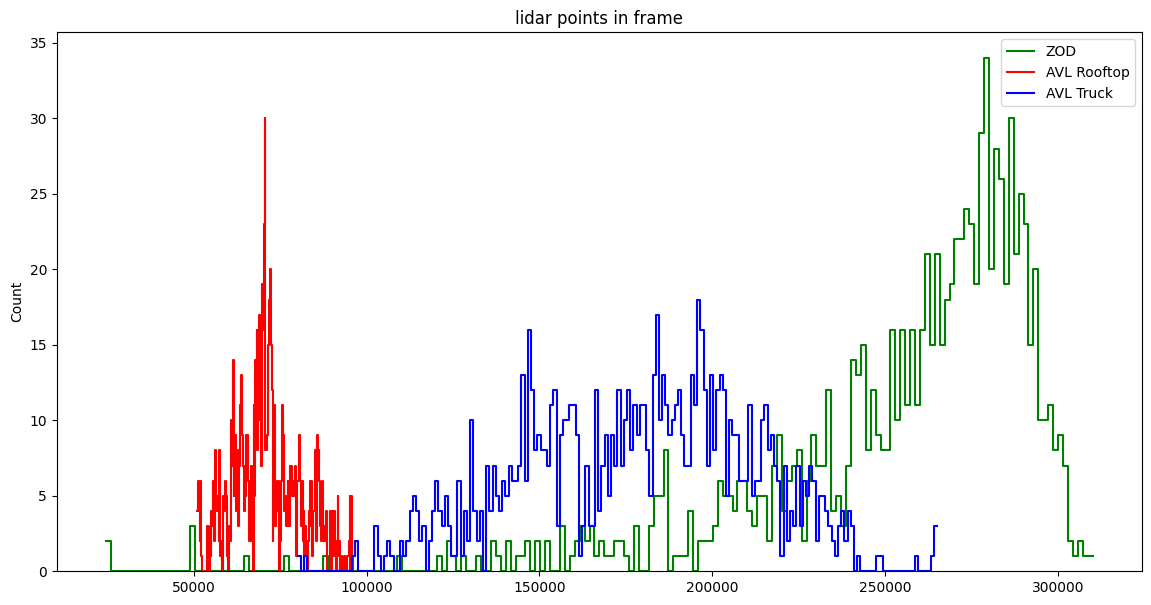

ZOD 255127.898
AVL Rooftop 71498.597
AVL Truck 178404.777


In [78]:

#get number of points each frame
def get_num_points(dataset, num_sample_frames):
    np.random.seed(2)        
    frame_indices = dataset.sample_id_list

    #randomly sample 1k frames from list
    np.random.seed(2)
    frame_indices = np.random.choice(frame_indices, num_sample_frames)

    points_per_frame = []
    for i, frame_idx in tqdm(enumerate(frame_indices)):
        #get points in frame
        points = dataset.get_lidar(frame_idx)
        
        points_per_frame.append(points.shape[0])
    
    return np.array(points_per_frame)

dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]

points_per_dataset = []
for i, dataset in enumerate(dataset_builders):
    dataset = dataset()
    dataset.fov_points_only = False
    dataset.train_fov_only = False
    points_per_dataset.append(get_num_points(dataset, 1000))

#print sns histo of points per frame
fig, ax = plt.subplots(1,1, figsize=(14,7))
for i, dataset_pts in enumerate(points_per_dataset):
    sns.histplot(dataset_pts, ax=ax, color=colors[i], label=labels[i],  bins=100, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)
ax.set_title("lidar points in frame")
ax.legend()
plt.show()

#print average
for i, dataset_pts in enumerate(points_per_dataset):
    print(labels[i], np.mean(dataset_pts)) 

In [10]:
#get bbox data
dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]
dataset_box_points = []
for i, dataset_builder in enumerate(dataset_builders):
    dataset = dataset_builder()

    box_points, name = get_bbox_points(dataset, classname[i], 50)
    dataset_box_points.append(box_points)



Loading infos: 0it [00:00, ?it/s]

 30%|███       | 15/50 [00:07<00:16,  2.15it/s]

No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 8.197421146338206


 72%|███████▏  | 36/50 [00:20<00:05,  2.50it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.676157887402788
No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 24.11968079325144


 96%|█████████▌| 48/50 [00:26<00:00,  4.25it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_2


 98%|█████████▊| 49/50 [00:27<00:00,  1.95it/s]

No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 9.118780365687327


 36%|███▌      | 18/50 [00:21<00:42,  1.32s/it]

No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 33.77970372980104
No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 34.23062052103571
No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 0.841030743499951
No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 0.9972770174042447


 54%|█████▍    | 27/50 [00:33<00:24,  1.06s/it]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-09-50-44_0_s0 with distance 23.262421360558246


 92%|█████████▏| 46/50 [00:52<00:05,  1.42s/it]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0 with distance 22.43593953845207


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


In [15]:
dataset_box_points.keys()

AttributeError: 'list' object has no attribute 'keys'

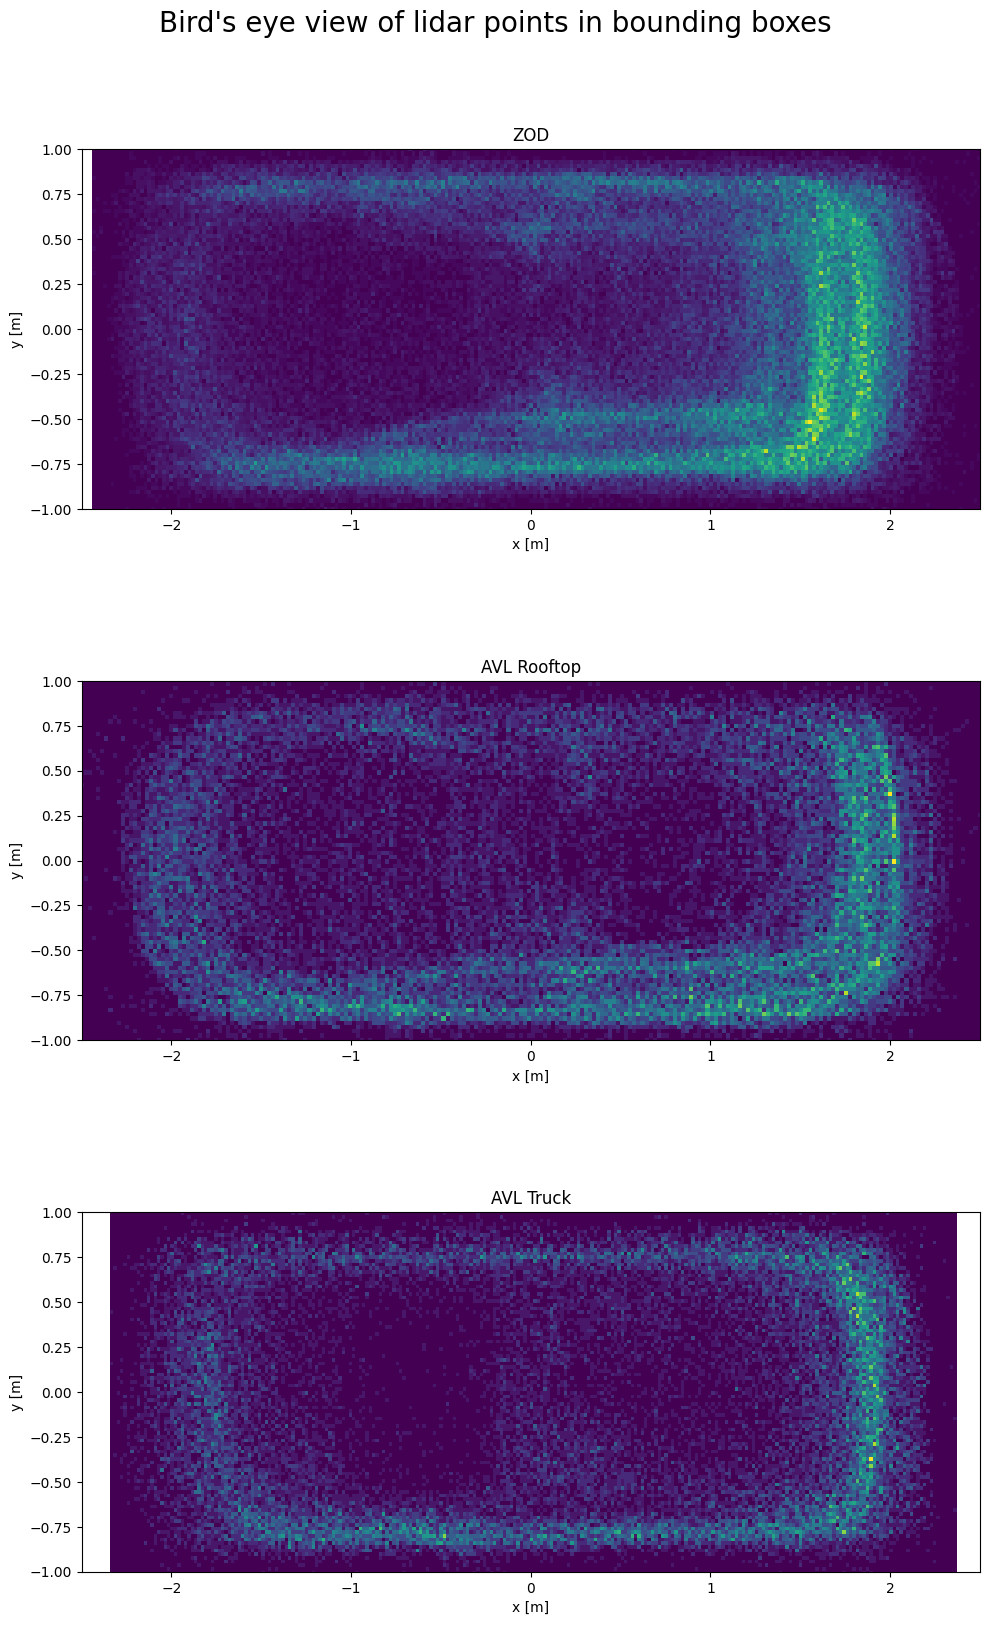

In [13]:
range_bins = [[0, 20], [20, 40], [40, 60], [60, 80], [80, 100], [100, 120]]  
#make a 2D histogram of the points (bird's eye view) for each dataset, and plot them in one fig with stacked plots
fig, ax = plt.subplots(3,1, figsize=(10,17))
xlimits = [-2.5, 2.5]
ylimits = [-1, 1]
xbins = int(xlimits[1] - xlimits[0] * 100)
ybins = int(ylimits[1] - ylimits[0] * 100)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,0], dataset_pts[:,1], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("y [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
fig.suptitle("Bird's eye view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()

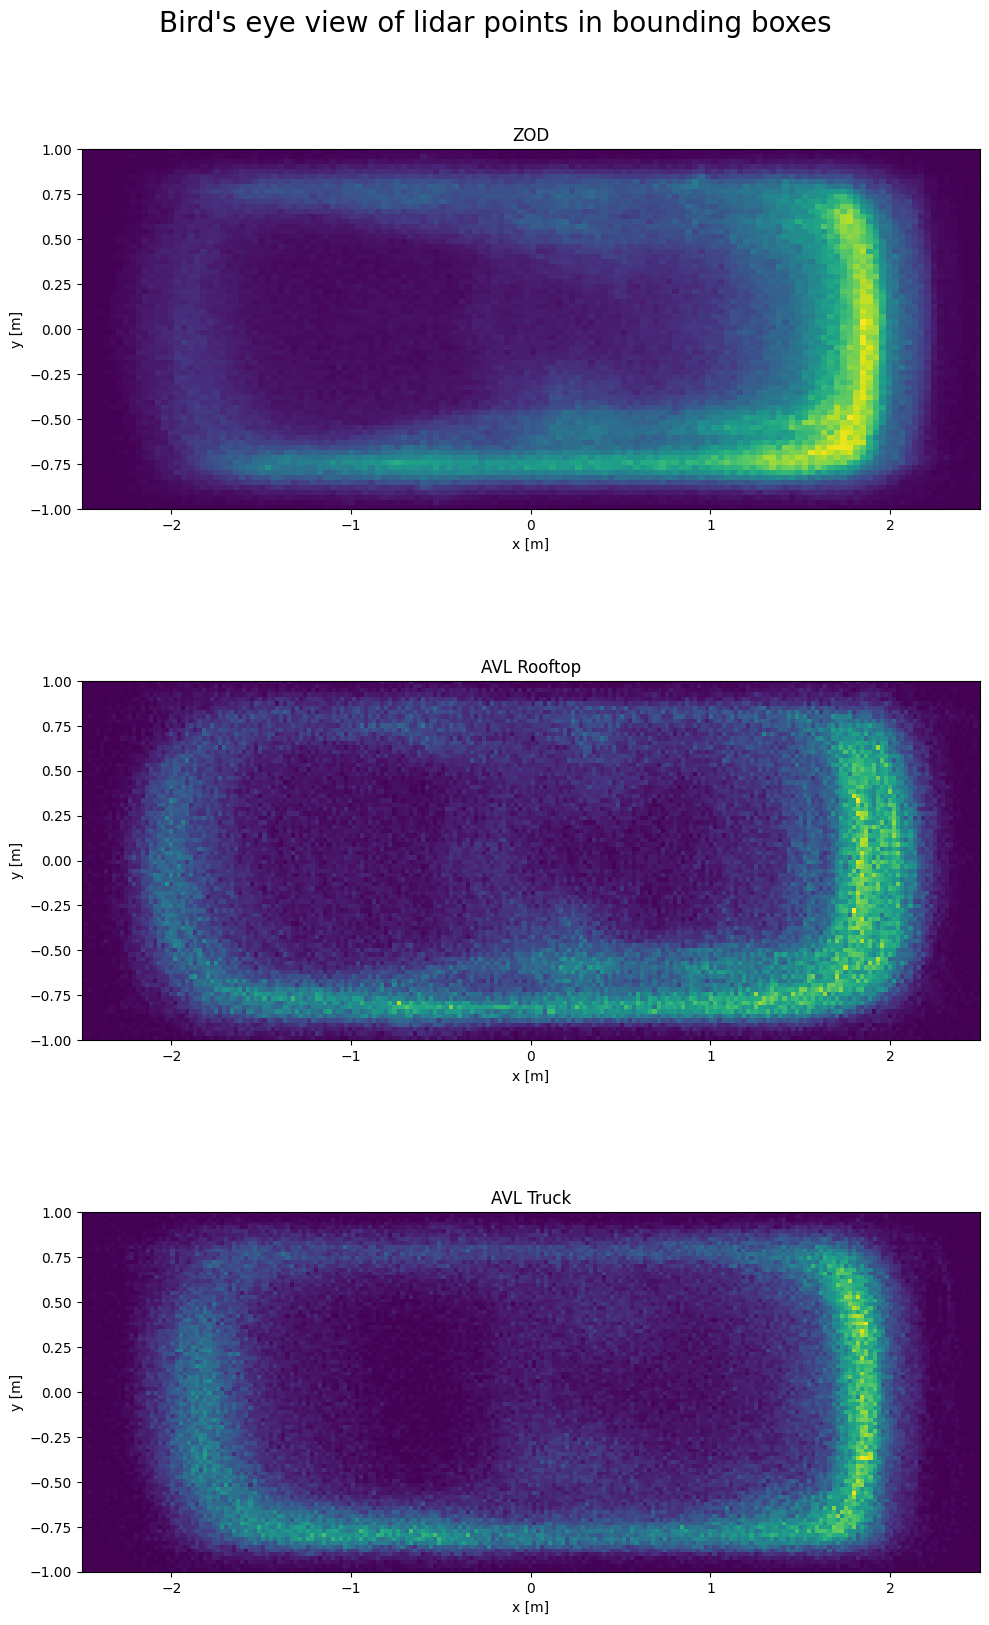

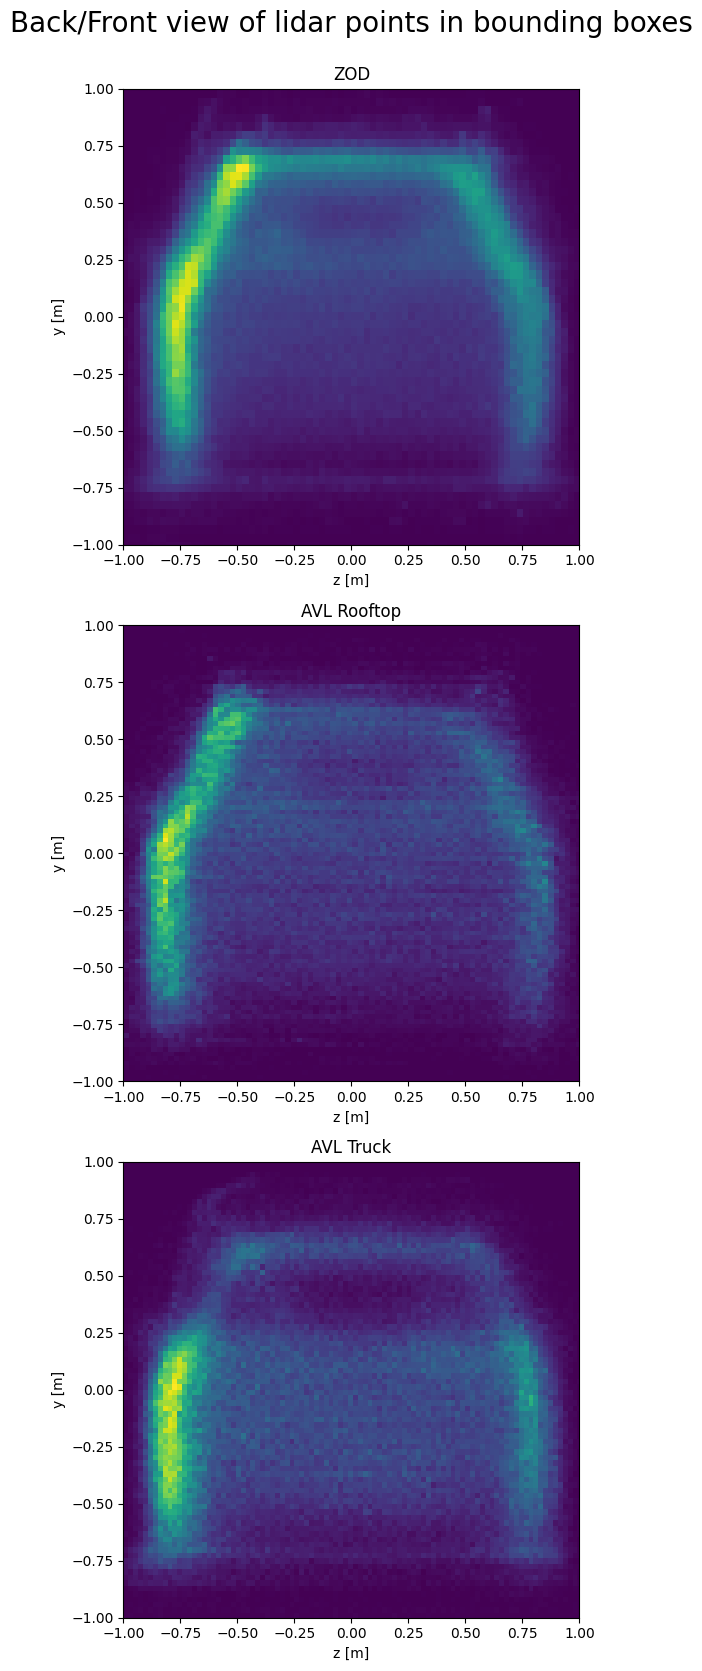

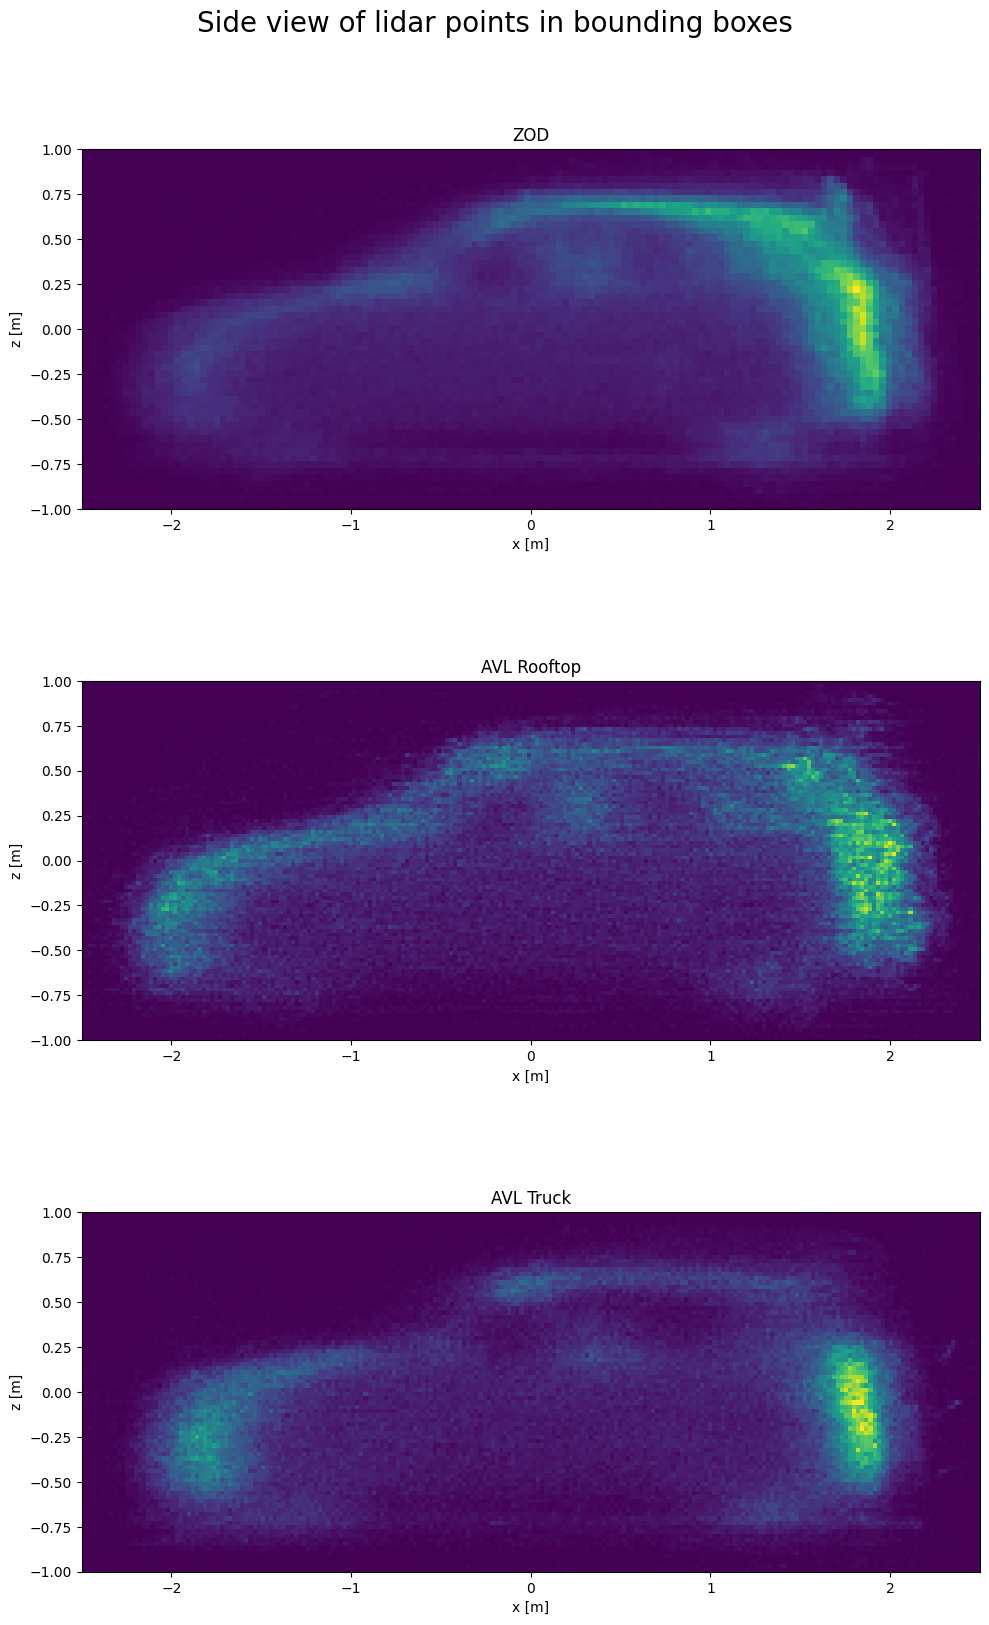

In [40]:
#make a 2D histogram of the points (bird's eye view) for each dataset, and plot them in one fig with stacked plots
fig, ax = plt.subplots(3,6, figsize=(10,17))
xlimits = [-2.5, 2.5]
ylimits = [-1, 1]
xbins = int(xlimits[1] - xlimits[0] * 100)
ybins = int(ylimits[1] - ylimits[0] * 100)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,0], dataset_pts[:,1], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("y [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
fig.suptitle("Bird's eye view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()

#anotherone from the back
fig, ax = plt.subplots(3,1, figsize=(10,17))
xlimits = [-1, 1]
ylimits = [-1, 1]
xbins = int(xlimits[1] - xlimits[0] * 100)
ybins = int(ylimits[1] - ylimits[0] * 100)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,1], dataset_pts[:,2], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("z [m]")
    ax[i].set_ylabel("y [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
#set fig name
fig.suptitle("Back/Front view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()


#make one for the side
fig, ax = plt.subplots(3,1, figsize=(10,17))
xlimits = [-2.5, 2.5]
ylimits = [-1, 1]
xbins = int(xlimits[1] - xlimits[0] * 100)
ybins = int(ylimits[1] - ylimits[0] * 100)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,0], dataset_pts[:,2], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("z [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
#set fig name
fig.suptitle("Side view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()



In [44]:
#get bbox data
dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Pedestrian"], ["Human"], ["Human"]]
colors = ["g", "r", "b"]
dataset_box_points = []
for i, dataset_builder in enumerate(dataset_builders):
    dataset = dataset_builder()

    box_points, name = get_bbox_points(dataset, classname[i], 500)
    dataset_box_points.append(box_points)



Loading infos: 0it [00:00, ?it/s]

  3%|▎         | 15/500 [00:01<00:51,  9.48it/s]

No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 8.197421146338206


  7%|▋         | 36/500 [00:02<00:27, 16.84it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.676157887402788
No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 24.11968079325144


 10%|▉         | 49/500 [00:03<00:17, 25.71it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_2
No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 9.118780365687327


 11%|█         | 56/500 [00:04<00:29, 15.13it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.855463601957368


 17%|█▋        | 85/500 [00:05<00:22, 18.39it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.40589497050391


 18%|█▊        | 88/500 [00:06<00:27, 14.81it/s]

No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 8.589830181880268


 19%|█▉        | 95/500 [00:07<00:38, 10.56it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 23%|██▎       | 116/500 [00:08<00:23, 16.07it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.4924869515421


 25%|██▌       | 126/500 [00:09<00:28, 12.96it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1 with distance 49.608801640626325


 27%|██▋       | 137/500 [00:10<00:20, 17.38it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 35%|███▌      | 176/500 [00:13<00:24, 13.00it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 38%|███▊      | 190/500 [00:13<00:15, 20.17it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.592464685798706
No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 24.003241687114695


 42%|████▏     | 210/500 [00:15<00:19, 14.63it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 44%|████▍     | 219/500 [00:16<00:23, 12.22it/s]

No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 8.328478893013497


 45%|████▍     | 223/500 [00:16<00:22, 12.36it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.359206558155754


 53%|█████▎    | 263/500 [00:19<00:12, 18.24it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.3799759354181709


 57%|█████▋    | 287/500 [00:20<00:11, 19.23it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_2
No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 60%|██████    | 301/500 [00:21<00:13, 14.51it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_2
No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.3628859252508858


 61%|██████    | 306/500 [00:22<00:14, 13.26it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 63%|██████▎   | 317/500 [00:22<00:09, 18.74it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.46653389291596
No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1 with distance 49.60151682977987


 66%|██████▌   | 331/500 [00:23<00:07, 23.41it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.4056802585458943


 68%|██████▊   | 342/500 [00:24<00:10, 14.92it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 70%|██████▉   | 349/500 [00:24<00:09, 15.89it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_2
No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.4119563342084542


 71%|███████   | 354/500 [00:24<00:08, 17.88it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 72%|███████▏  | 361/500 [00:25<00:07, 19.55it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.4056802585458943


 74%|███████▍  | 369/500 [00:25<00:09, 14.04it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 75%|███████▌  | 376/500 [00:26<00:08, 13.98it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.443480901116157
No human label found for bike label in sequence CITY_Sunny_street_20200319140700_3 with distance 1.3651536748389157


 77%|███████▋  | 385/500 [00:26<00:05, 21.36it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 81%|████████▏ | 407/500 [00:27<00:04, 20.89it/s]

No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.592464685798706


 84%|████████▍ | 422/500 [00:28<00:03, 20.27it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 86%|████████▌ | 431/500 [00:29<00:03, 20.22it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 93%|█████████▎| 465/500 [00:31<00:02, 14.25it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1


 95%|█████████▍| 474/500 [00:32<00:02, 11.36it/s]

No human label found for bike label in sequence CITY_Normal_roundabout_20200320100220_2 with distance 8.721560085804128


 99%|█████████▊| 493/500 [00:35<00:00, 12.51it/s]

No human label found for bike label in sequence CITY_Sunny_street_20200319140730_1
No human label found for bike label in sequence INTERURBAN_Normal_roundabout_20200519125055 with distance 23.443480901116157
No human label found for bike label in sequence CITY_Sunny_street_20200319140730_2


  2%|▏         | 10/500 [00:01<01:01,  7.93it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 33.77970372980104
No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 34.23062052103571
No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 0.841030743499951
No human label found for bike label in sequence CityStreet_dgt_2021-08-19-12-31-50_0_s0 with distance 0.9972770174042447


  4%|▍         | 21/500 [00:01<00:39, 12.03it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-09-50-44_0_s0 with distance 23.262421360558246


  9%|▉         | 46/500 [00:03<00:20, 21.97it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0 with distance 22.43593953845207


 10%|▉         | 49/500 [00:05<01:31,  4.92it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0 with distance 22.43593953845207


 11%|█         | 56/500 [00:07<01:48,  4.10it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-13-12-09-16_0_s0


 14%|█▍        | 70/500 [00:08<00:49,  8.72it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0 with distance 6.712976446782697
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0 with distance 5.77546496949764
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0 with distance 5.604404262090411


 16%|█▌        | 78/500 [00:09<00:42, 10.04it/s]

No human label found for bike label in sequence Motorway_dgt_2021-09-15-09-29-02_0_s0 with distance 21.685152089269852


 19%|█▉        | 94/500 [00:11<00:41,  9.84it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-09-24-52_0_s0 with distance 17.15203941127157


 23%|██▎       | 116/500 [00:19<01:22,  4.67it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-14-10-24-14_0_s0


 24%|██▍       | 122/500 [00:22<02:38,  2.39it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 19.07534266008094
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 23.632248059072694
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 21.679088330778708
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 22.203306431955607
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 5.070891933299768
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 4.346736434197504
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 15.803071634639984
No human label found for bike label in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0 with distance 18.044714914161734
No human label found for bike label

 25%|██▌       | 125/500 [00:25<03:46,  1.66it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-13-12-09-16_0_s0


 27%|██▋       | 134/500 [00:26<00:58,  6.29it/s]

No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-23-10-02-33_0_s0
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-13-05-38_0_s0 with distance 38.25337221128437
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-13-05-38_0_s0 with distance 37.94138094070495
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-13-05-38_0_s0 with distance 35.4829253853751
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-13-05-38_0_s0 with distance 35.87104010539693


 27%|██▋       | 136/500 [00:27<01:39,  3.67it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-09-03-11-33-29_0_s0
No human label found for bike label in sequence CityThoroughfare_dgt_2021-09-03-11-33-29_0_s0
No human label found for bike label in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0 with distance 16.645910422877527
No human label found for bike label in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0 with distance 18.137568730269248
No human label found for bike label in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0 with distance 8.903654492013041
No human label found for bike label in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0 with distance 13.89418708792375


 28%|██▊       | 141/500 [00:30<02:22,  2.51it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0 with distance 9.843211284447372
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0 with distance 11.411611912124721
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0 with distance 11.844131976765935


 32%|███▏      | 160/500 [00:33<01:22,  4.11it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 25.407574549519524
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 24.649763377616814
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 21.399011114420937
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 23.169400168023568
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 35.55906268810992
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 34.639431995390595


 33%|███▎      | 167/500 [00:35<00:57,  5.81it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-09-50-44_0_s0 with distance 22.8185315667466


 36%|███▌      | 179/500 [00:39<01:36,  3.34it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-11-26-11-15-33_0_s0 with distance 26.93600003948043


 36%|███▋      | 182/500 [00:40<01:34,  3.35it/s]

No human label found for bike label in sequence Motorway_dgt_2021-09-15-13-37-29_0_s0
No human label found for bike label in sequence Motorway_dgt_2021-09-15-13-37-29_0_s0
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-09-50-44_0_s0 with distance 23.245271339613456


 37%|███▋      | 183/500 [00:40<01:51,  2.84it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 20.927109285171575
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 21.446918686704198
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 19.779338094029605
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 18.484931721082823
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 17.954504836057676
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 19.248301361327172
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 18.22368884749065
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 15.53668915393365
No human label found for bike labe

 38%|███▊      | 191/500 [00:46<01:57,  2.63it/s]

No human label found for bike label in sequence Motorway_dgt_2021-08-20-13-11-25_0_s0


 40%|████      | 200/500 [00:47<00:56,  5.36it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0 with distance 9.75021380958501
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0 with distance 11.198323872704409
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0 with distance 10.465198402178057


 41%|████      | 205/500 [00:50<01:28,  3.35it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-12-12-37-25_0_s0 with distance 18.692982036024645


 43%|████▎     | 217/500 [00:54<01:05,  4.34it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 17.69213420586888
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 17.767457015449178
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 16.749726140762657
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 15.17226511165153
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 6.016014502973979
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 6.548495931416274
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 5.366227246890692
No human label found for bike label in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0 with distance 7.904703664300559
No human label found for bike label in

 46%|████▌     | 231/500 [00:59<01:03,  4.25it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 6.425983396723439
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 1.5434313139324014
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 4.843112471708305
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 4.207273373572047
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 5.011834946375467
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 5.7642800828320215
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 5.570338344954633
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0 with distance 6.324616788909341
No human label found for bike label in

 47%|████▋     | 235/500 [01:05<03:08,  1.41it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 6.932690558493211
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 4.049485570345909
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 4.447451101634007
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 25.3656627242269
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 25.57523221208543
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 25.222535494223695
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 7.59109241390746
No human label found for bike label in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0 with distance 2.9751583894809346
No human label found for bike label in s

 48%|████▊     | 242/500 [01:09<01:38,  2.63it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-14-09-55-12_0_s0 with distance 14.976916205321455


 50%|█████     | 252/500 [01:16<02:40,  1.54it/s]

No human label found for bike label in sequence Motorway_dgt_2021-08-20-13-11-25_0_s0


 51%|█████     | 254/500 [01:18<02:40,  1.53it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-07-12-20-59_0_s0 with distance 42.72138112230829


 52%|█████▏    | 259/500 [01:21<02:21,  1.70it/s]

No human label found for bike label in sequence Motorway_dgt_2021-08-20-12-48-38_0_s0


 52%|█████▏    | 261/500 [01:21<01:30,  2.65it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0 with distance 6.712976446782697
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0 with distance 5.77546496949764
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0 with distance 5.604404262090411


 54%|█████▍    | 269/500 [01:24<01:08,  3.35it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.7549866939955647
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 17.450959528302267
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 22.2373216625103
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.60991520388201
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.0727773772709157
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 21.518051520292982
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 11.294715419532503
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.4105960749321556


 54%|█████▍    | 272/500 [01:26<01:36,  2.37it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0 with distance 9.197876046215125
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0 with distance 13.479986250787787
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0 with distance 13.253126297259042
No human label found for bike label in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0 with distance 11.926883133499379


 56%|█████▌    | 280/500 [01:29<01:12,  3.05it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-01-46_0_s0 with distance 74.38667118513602


 58%|█████▊    | 290/500 [01:32<01:08,  3.06it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0 with distance 34.85612871643986
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0 with distance 34.56931969505044


 59%|█████▉    | 294/500 [01:34<01:29,  2.29it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 18.252545616519953
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 17.833189897509595
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 10.272091790511446
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 11.940714612236746
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 10.246408035070171
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 14.032124622029334
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 16.62234925389572
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0 with distance 3.544294853107231
No human label found for bike labe

 61%|██████    | 304/500 [01:36<00:39,  5.01it/s]

No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-08-10-38-24_0_s0
No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-08-10-38-24_0_s0


 61%|██████▏   | 307/500 [01:37<00:38,  5.07it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-11-03-12-04-20_0_s0 with distance 59.222774977759244


 62%|██████▏   | 311/500 [01:37<00:27,  6.84it/s]

No human label found for bike label in sequence Motorway_dgt_2021-09-15-13-37-29_0_s0
No human label found for bike label in sequence Motorway_dgt_2021-09-15-13-37-29_0_s0


 63%|██████▎   | 317/500 [01:38<00:21,  8.52it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-12-49-16_0_s0


 64%|██████▍   | 321/500 [01:38<00:18,  9.55it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-08-14-30-08_0_s0 with distance 44.853498060481016


 66%|██████▌   | 329/500 [01:40<00:31,  5.51it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-07-13_0_s0
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-07-13_0_s0
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-13-07-13_0_s0


 71%|███████   | 354/500 [01:46<00:44,  3.28it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0 with distance 32.405004045163025
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0 with distance 32.03861510878223


 72%|███████▏  | 358/500 [01:46<00:26,  5.35it/s]

No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0
No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0
No human label found for bike label in sequence CityThoroughfare_dgt_2021-09-03-11-27-28_0_s0 with distance 28.336779693361795
No human label found for bike label in sequence CityThoroughfare_dgt_2021-09-03-11-27-28_0_s0 with distance 28.336779693361795


 73%|███████▎  | 365/500 [01:48<00:44,  3.05it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-12-49-16_0_s0
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-08-14-30-08_0_s0 with distance 44.853498060481016


 74%|███████▎  | 368/500 [01:49<00:44,  2.94it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.6231318511860873
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 16.830645534784953
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 21.214150530586515
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 3.1788937140470006
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 3.0372824705165677
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 22.061107527509964
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 12.346734498503395
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.3977827099289404


 75%|███████▍  | 374/500 [01:53<00:54,  2.31it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0 with distance 32.405004045163025
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0 with distance 32.03861510878223


 75%|███████▌  | 376/500 [01:53<00:38,  3.20it/s]

No human label found for bike label in sequence Motorway_dgt_2021-09-15-09-29-02_0_s0 with distance 21.685152089269852


 78%|███████▊  | 389/500 [01:56<00:17,  6.33it/s]

No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-12-13-38-27_0_s0
No human label found for bike label in sequence PrimaryHighway_dgt_2021-07-12-13-38-27_0_s0


 80%|████████  | 400/500 [02:02<00:37,  2.68it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 0.7138485854274718
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 4.279315263997416
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 5.5567411097168415
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 3.4028220110148517
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 1.564391127140994
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 1.8201490908526086
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 3.3468725449624146
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0 with distance 4.225062162398658
No human label found for bike label

 82%|████████▏ | 408/500 [02:04<00:17,  5.30it/s]

No human label found for bike label in sequence Motorway_dgt_2021-09-15-13-40-00_0_s0
No human label found for bike label in sequence Motorway_dgt_2021-09-15-13-40-00_0_s0


 83%|████████▎ | 413/500 [02:04<00:10,  8.03it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0 with distance 14.409103409283762


 85%|████████▍ | 423/500 [02:06<00:12,  6.42it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-07-12-53-49_0_s0 with distance 8.886437623373853
No human label found for bike label in sequence CityStreet_dgt_2021-07-07-12-53-49_0_s0 with distance 9.032233634967735


 85%|████████▌ | 425/500 [02:08<00:26,  2.81it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 25.405895689726435
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 24.648072123839977
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 21.415076312146503
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 23.1845309105381
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 35.55233057275257
No human label found for bike label in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0 with distance 34.63314666038066


 91%|█████████▏| 457/500 [02:20<00:07,  5.38it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.6467858334621965
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 17.223614429369004
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 25.469436128021822
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.6891262081300047
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.4115762731008425
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 21.745343087292873
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 11.660570954223575
No human label found for bike label in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0 with distance 2.4090095489971453


 92%|█████████▏| 460/500 [02:22<00:16,  2.39it/s]

No human label found for bike label in sequence Motorway_dgt_2021-09-03-12-48-09_0_s0
No human label found for bike label in sequence Motorway_dgt_2021-09-03-12-48-09_0_s0
No human label found for bike label in sequence Motorway_dgt_2021-09-03-12-48-09_0_s0


 93%|█████████▎| 465/500 [02:23<00:09,  3.74it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 12.82751534161467
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 12.609629392635695
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 22.6155259645751
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 21.483896354622512
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 4.806445704371215
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 5.525784945243924
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 1.4811012688302139
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0 with distance 3.105113761760062
No human label found for bike label in

 97%|█████████▋| 485/500 [02:29<00:04,  3.07it/s]

No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0 with distance 3.0717289860828725
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0 with distance 2.9898462213484587
No human label found for bike label in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0 with distance 3.122775576847463


 98%|█████████▊| 490/500 [02:33<00:05,  1.78it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 5.1585513389257756
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 5.656167253430283
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 6.089465758171835
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 6.699186856511027
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 7.261071024531711
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 8.436356406536024
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 9.143611413984397
No human label found for bike label in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0 with distance 10.34193585432516
No human label found for bike label in 

100%|█████████▉| 499/500 [02:36<00:00,  4.09it/s]

No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 20.93108859675308
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 21.595303865325818
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 19.7783578943287
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 18.48544951856897
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 17.954984502503955
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 19.284833737569894
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 18.775003872205232
No human label found for bike label in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0 with distance 18.261052928018604
No human label found for bike label 

100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


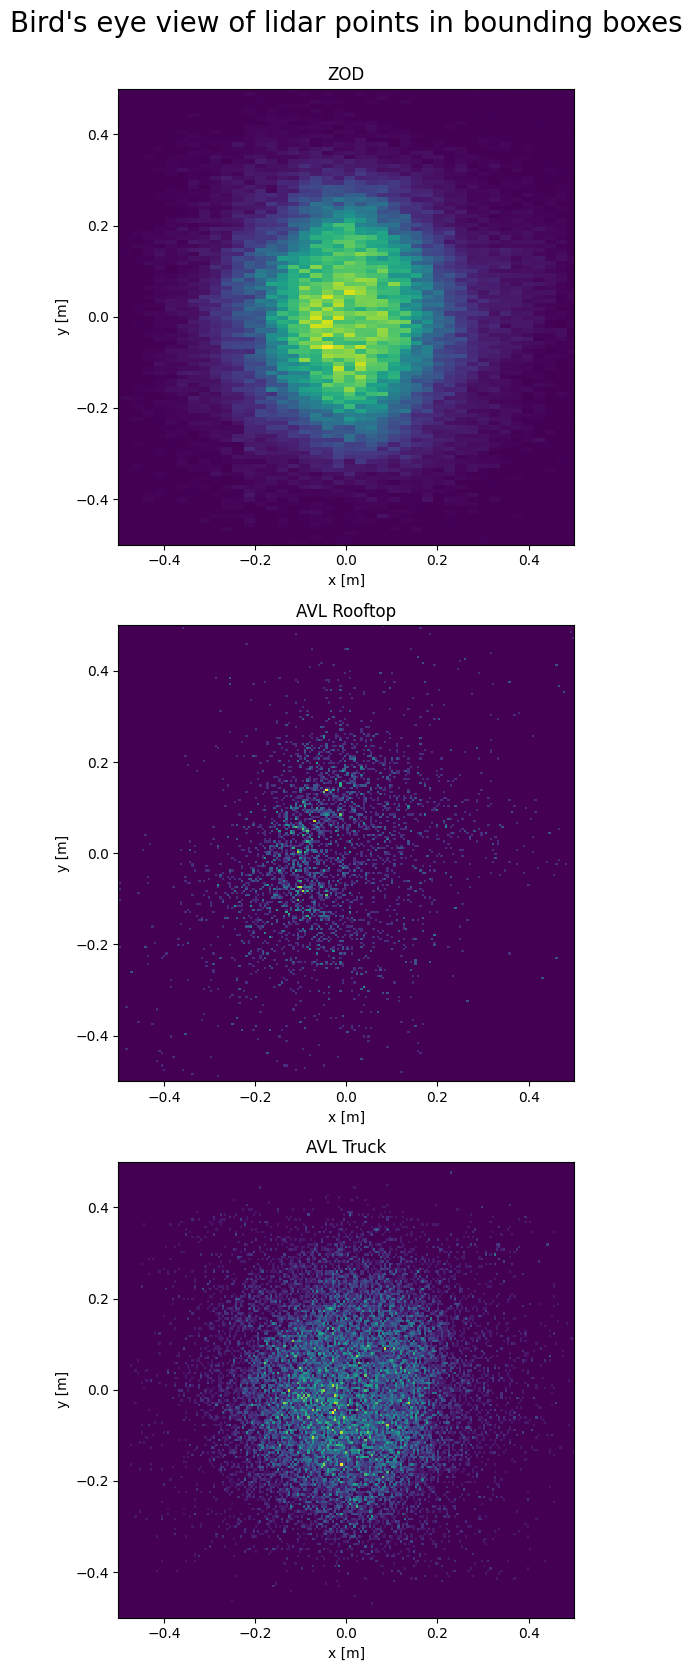

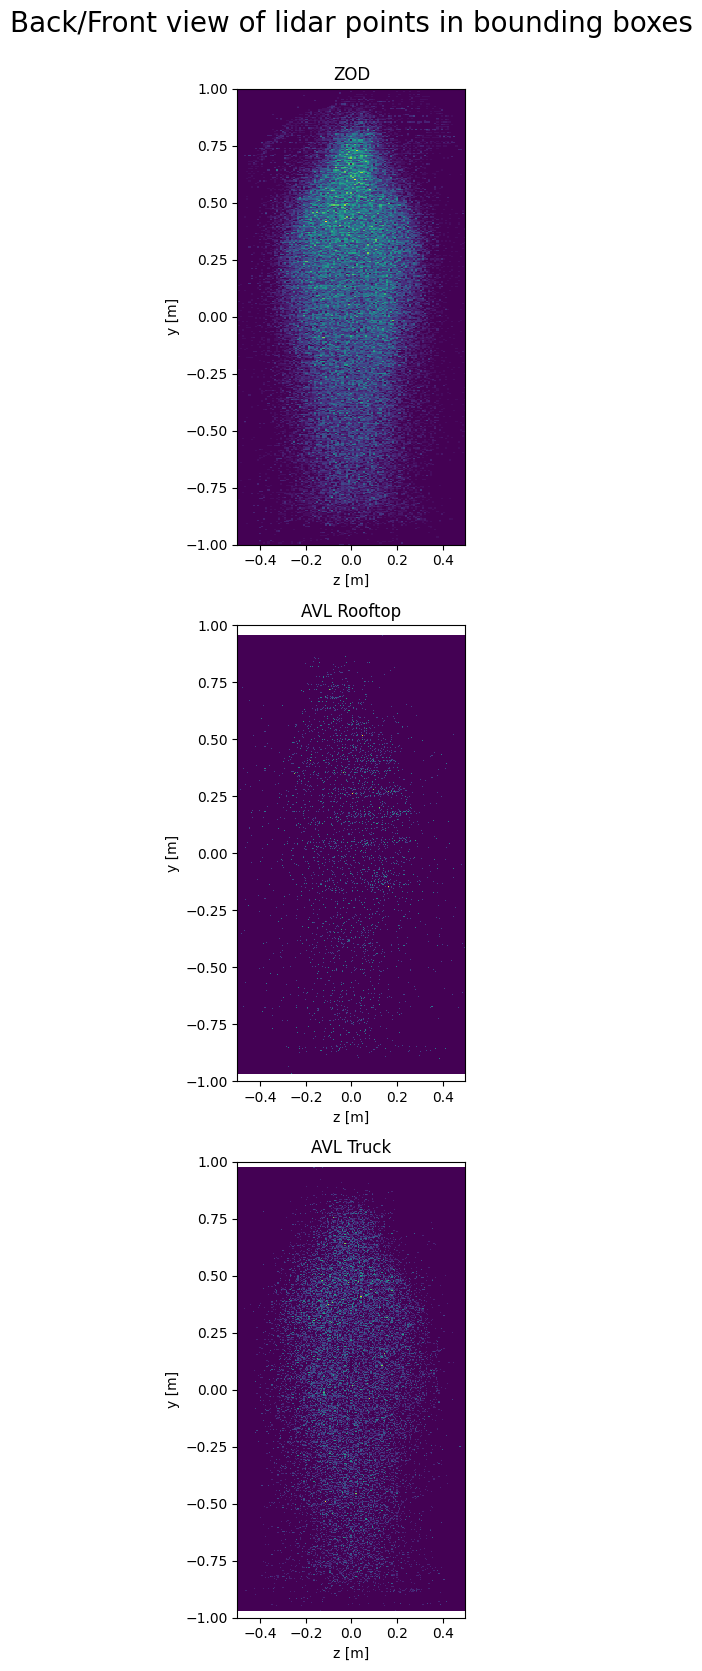

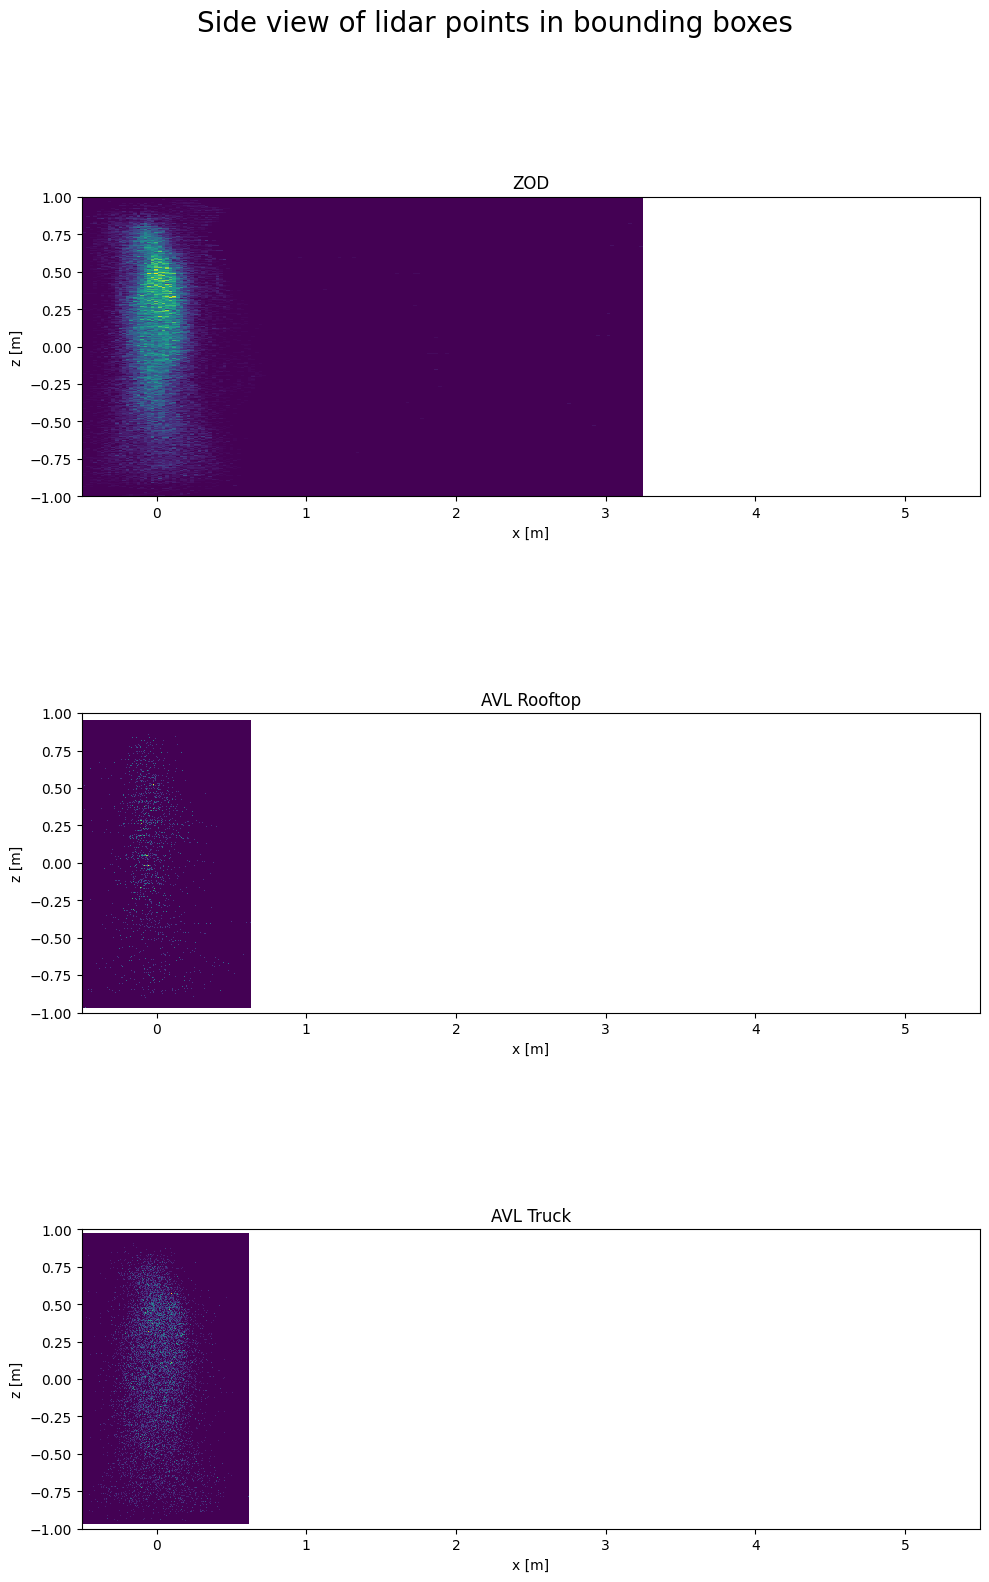

In [46]:
#make a 2D histogram of the points (bird's eye view) for each dataset, and plot them in one fig with stacked plots
fig, ax = plt.subplots(3,1, figsize=(10,17))
xlimits = [-0.5, 0.5]
ylimits = [-0.5, 0.5]
xbins = int(xlimits[1] - xlimits[0] * 500)
ybins = int(ylimits[1] - ylimits[0] * 500)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,0], dataset_pts[:,1], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("y [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
fig.suptitle("Bird's eye view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()

#anotherone from the back
fig, ax = plt.subplots(3,1, figsize=(10,17))
xlimits = [-0.5, 0.5]
ylimits = [-1, 1]
xbins = int(xlimits[1] - xlimits[0] * 500)
ybins = int(ylimits[1] - ylimits[0] * 500)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,1], dataset_pts[:,2], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("z [m]")
    ax[i].set_ylabel("y [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
#set fig name
fig.suptitle("Back/Front view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()


#make one for the side
fig, ax = plt.subplots(3,1, figsize=(10,17))
xlimits = [-0.5, 5.5]
ylimits = [-1, 1]
xbins = int(xlimits[1] - xlimits[0] * 500)
ybins = int(ylimits[1] - ylimits[0] * 500)
bins = [xbins, ybins]
for i, dataset_pts in enumerate(dataset_box_points):
    ax[i].hist2d(dataset_pts[:,0], dataset_pts[:,2], bins=bins, cmap='viridis', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlim(xlimits)
    ax[i].set_ylim(ylimits)
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("z [m]")
    #aspect ratio
    ax[i].set_aspect('equal')
#set fig name
fig.suptitle("Side view of lidar points in bounding boxes\n", fontsize=20)
plt.tight_layout()
plt.show()



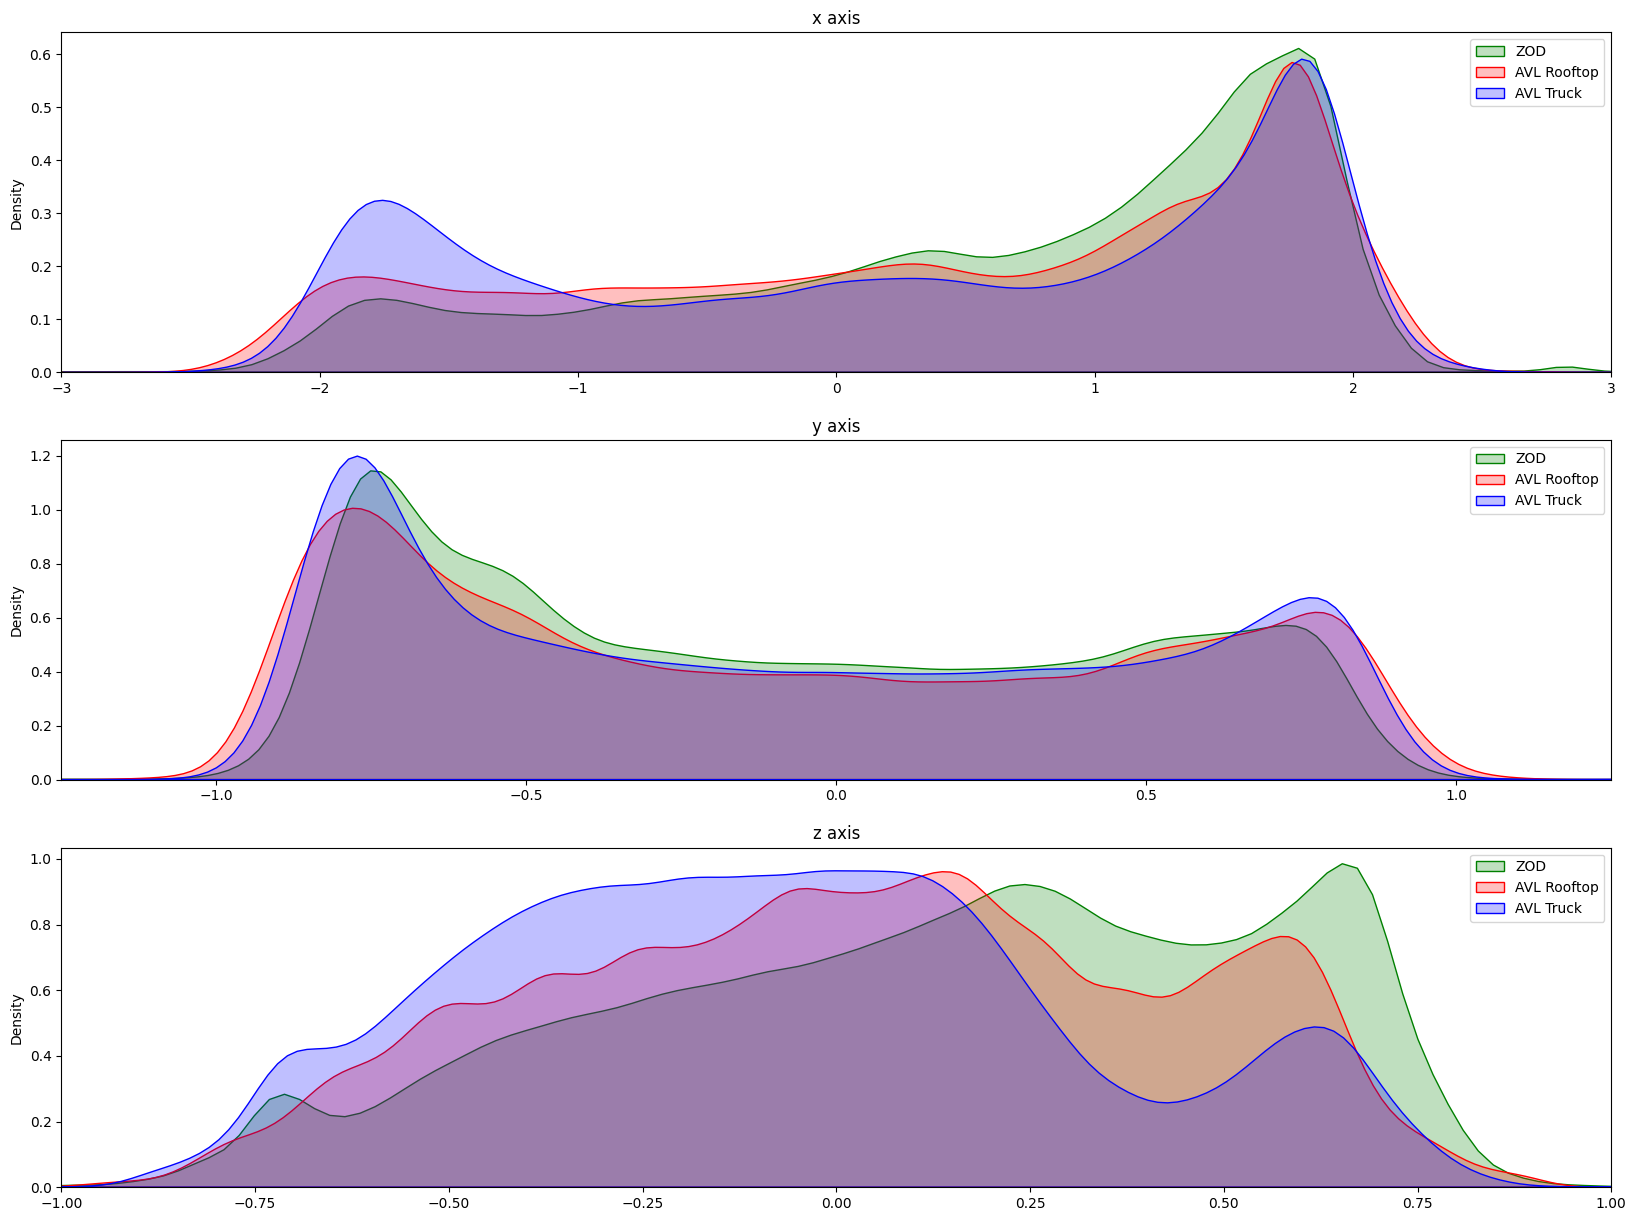

In [9]:
# for each dataset plot a normalized histogram of the points over all boxes for x, y and z axis
fig, ax = plt.subplots(3,1, figsize=(20,15))
for i, dataset in enumerate(dataset_box_points):
    sns.distplot(dataset[:,0], ax=ax[0], color=colors[i], hist=False, kde_kws={"shade": True, "fill":False}, label=labels[i])
    sns.distplot(dataset[:,1], ax=ax[1], color=colors[i], hist=False, kde_kws={"shade": True, "fill":False}, label=labels[i])
    sns.distplot(dataset[:,2], ax=ax[2], color=colors[i], hist=False, kde_kws={"shade": True, "fill":False}, label=labels[i])
ax[0].set_title("x axis")
ax[1].set_title("y axis")
ax[2].set_title("z axis")
ax[0].legend()
ax[1].legend()
ax[2].legend()
#set limits
ax[0].set_xlim([-3,3])
ax[1].set_xlim([-1.25,1.25])
ax[2].set_xlim([-1,1])

plt.show()



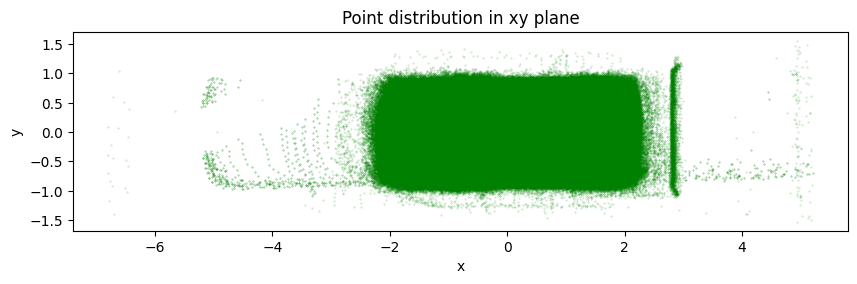

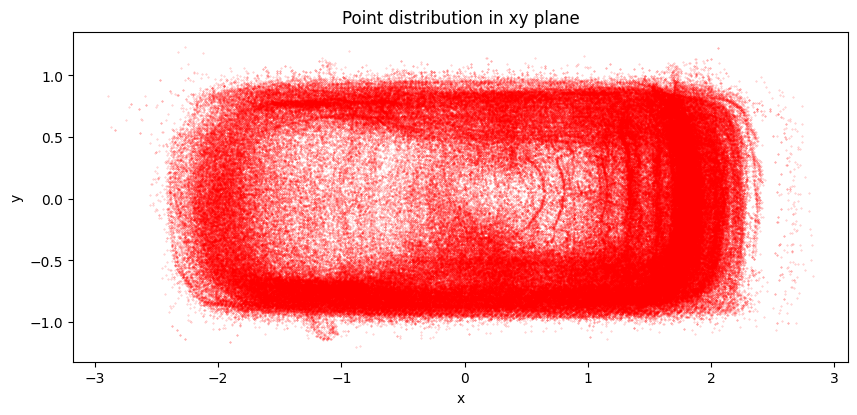

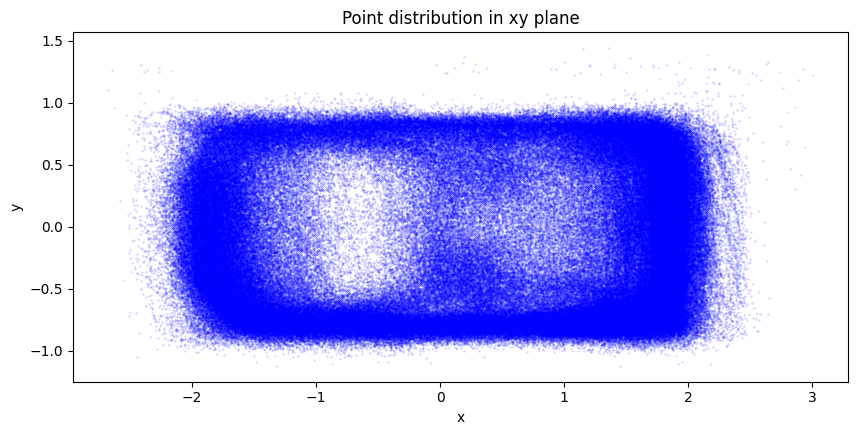

In [10]:
for i, box_points in enumerate(dataset_box_points):    
    plt.figure(figsize=(10,10))
    #plot point distribution in xy plane
    plt.scatter(box_points[:,0], box_points[:,1], s=0.1, alpha=0.33, c=colors[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Point distribution in xy plane")
    #aspect ratio 1:1
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

### Analyze points in frames

In [13]:
def get_random_points(dataset, num_sample_frames, num_sample_points):
    np.random.seed(2)        
    frame_indices = dataset.sample_id_list

    #randomly sample 1k frames from list
    np.random.seed(2)
    frame_indices = np.random.choice(frame_indices, num_sample_frames)

    points_array = np.zeros([num_sample_frames*num_sample_points,4])
    for i, frame_idx in tqdm(enumerate(frame_indices)):
        #get points in frame
        points = dataset.get_lidar(frame_idx)
        
        points = points[np.random.choice(points.shape[0], num_sample_points)]

        points_array[i*num_sample_points:num_sample_points*(i+1)] = points

    return points_array


In [14]:

#get random points from datasets
dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]
points = []
for i, dataset_builder in enumerate(dataset_builders):
    dataset = dataset_builder()

    points_dataset = get_random_points(dataset, 500, 10000)
    points.append(points_dataset)

Loading infos: 0it [00:00, ?it/s]

500it [00:24, 20.42it/s]
500it [00:01, 350.46it/s]
500it [00:04, 108.73it/s]


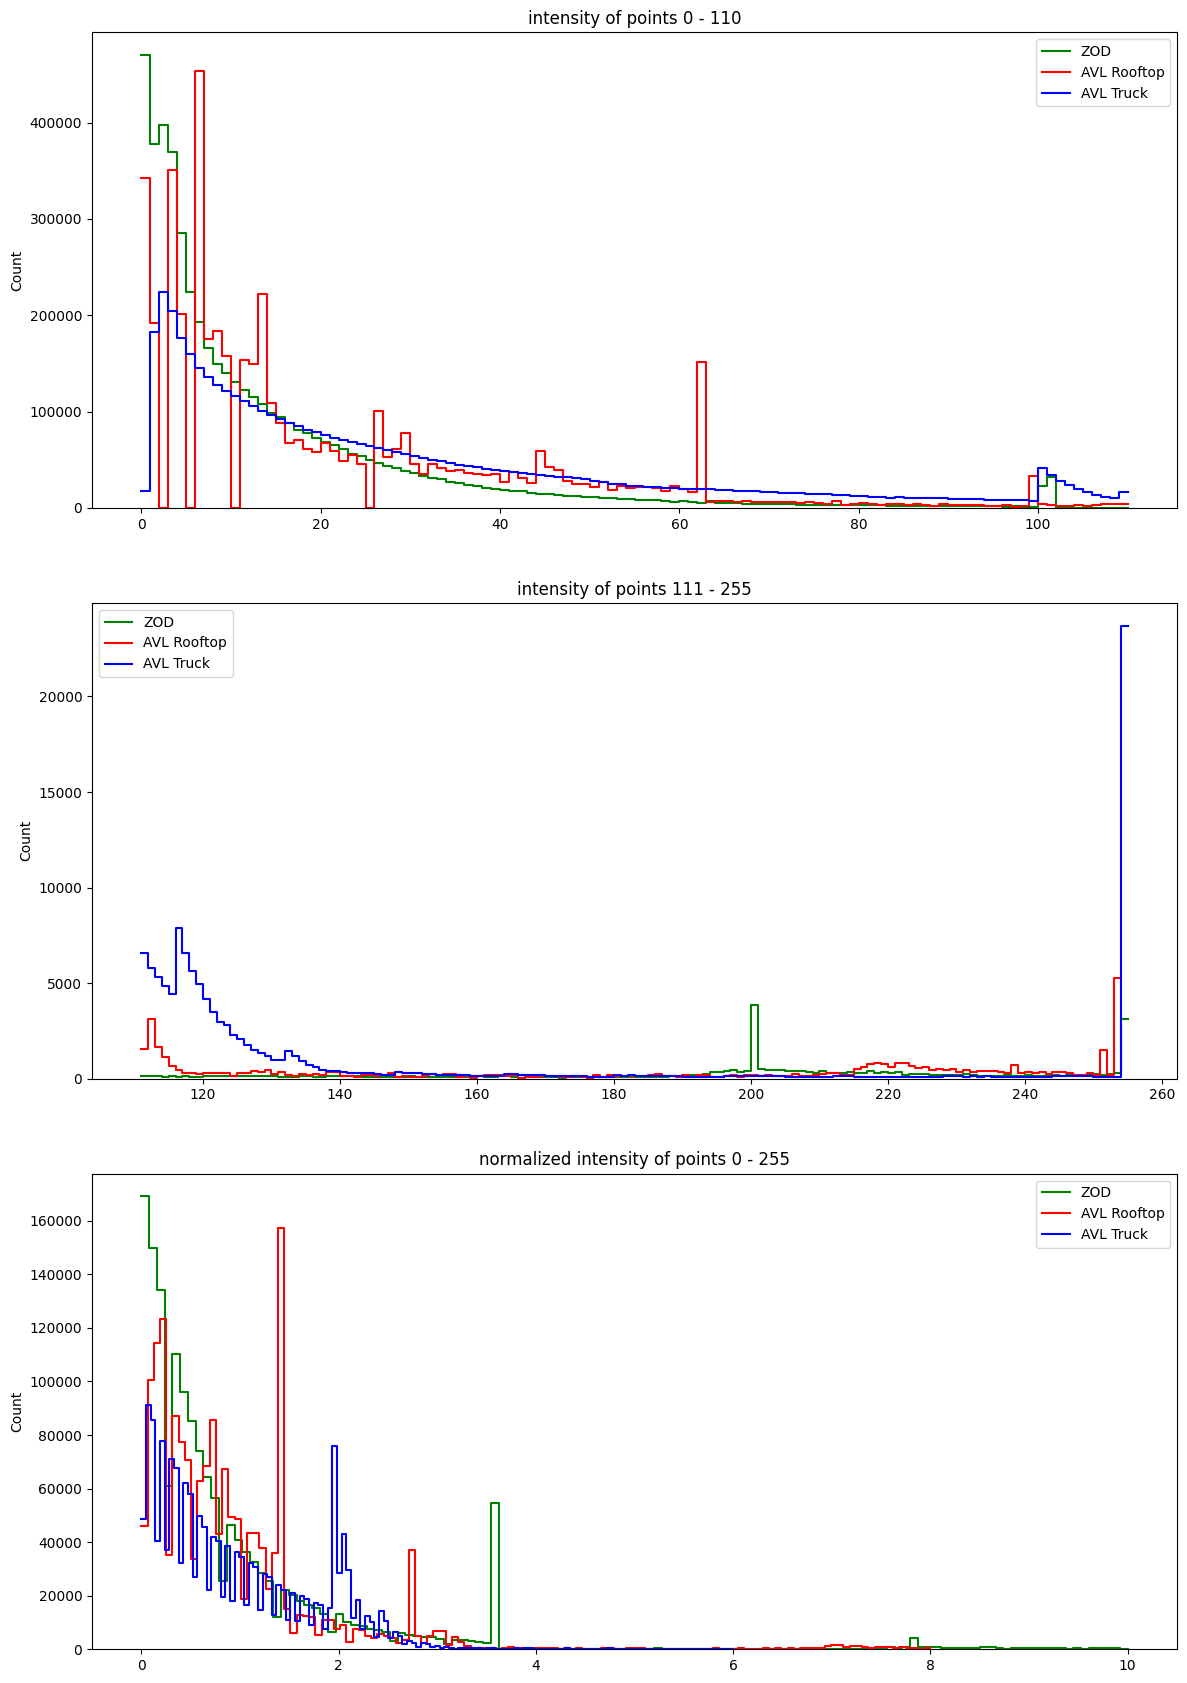

In [33]:
#analyze intensity of points
fig, ax = plt.subplots(3,1, figsize=(14,21))
for i, dataset_pts in enumerate(points):
    points_intensity = dataset_pts[:,3].copy() 
    points_intensity*=255
    points_intensity = points_intensity.astype(int)
    #filter points with intensity lower than 0.5
    pts_low = points_intensity[points_intensity <= 110]       
    bins = range(min(pts_low), max(pts_low) + 1)
    sns.histplot(pts_low, ax=ax[0], color=colors[i], label=labels[i],  bins=bins, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=False)
    
    pts_high = points_intensity[points_intensity > 110]
    bins = range(min(pts_high), max(pts_high) + 1)
    sns.histplot(pts_high, ax=ax[1], color=colors[i], label=labels[i],  bins=bins, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=False)
    #sns.distplot(dataset_pts[:,3], ax=ax, color=colors[i], hist=False, kde_kws={"shade": True, "bw_adjust": 0.1}, label=labels[i])
    
    #normalize intensity to have mean zero and std 1
    norm_points = (points_intensity - np.mean(points_intensity))/np.std(points_intensity)
    bins = np.linspace(int(min(norm_points)), int(max(norm_points)), 128)
    sns.histplot(norm_points, ax=ax[2], color=colors[i], label=labels[i],  bins=bins, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=False)

ax[0].set_title("intensity of points 0 - 110")
ax[1].set_title("intensity of points 111 - 255")
ax[2].set_title("normalized intensity of points 0 - 255")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()


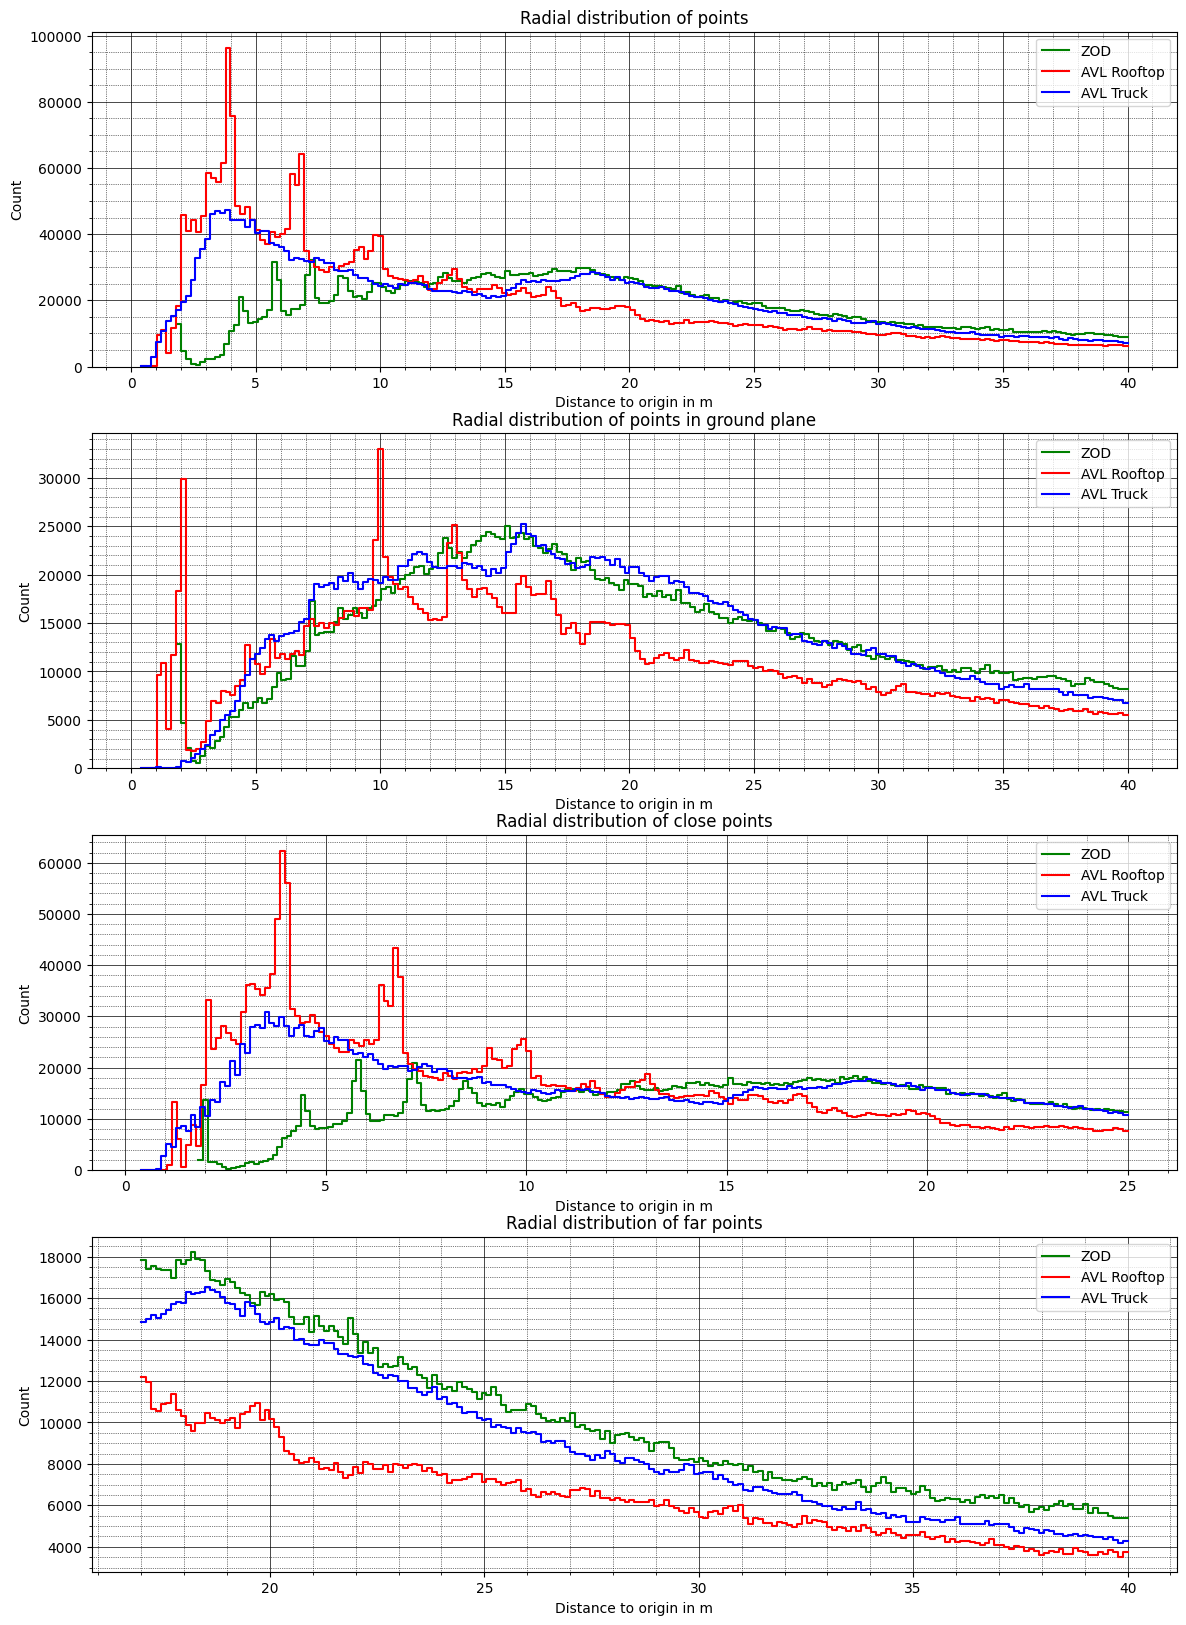

In [79]:
#print radial data dist
fig, ax = plt.subplots(4,1, figsize=(14,20))
x_limits = [0,40]
x_limits_far = [17,40]
x_limits_close= [0,25]
for i, pts in enumerate(points):

    dists = np.linalg.norm(pts[:,0:2], axis=1)
    #filter points within x_limits
    dists = dists[np.logical_and(dists > x_limits[0], dists < x_limits[1])]

    sns.histplot(dists, ax=ax[0], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)
    
    dists_close = dists[np.logical_and(dists > x_limits_close[0], dists < x_limits_close[1])]
    sns.histplot(dists_close, ax=ax[2], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)

    dists_far = dists[np.logical_and(dists > x_limits_far[0], dists < x_limits_far[1])]
    sns.histplot(dists_far, ax=ax[3], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)

    #filter gt plane points
    pts = pts[np.abs(pts[:,2]) < 0.2]
    
    #filter points within x_limits
    dists_ground = np.linalg.norm(pts[:,0:2], axis=1)
    dists_ground = dists_ground[np.logical_and(dists_ground > x_limits[0], dists_ground < x_limits[1])]
    sns.histplot(dists_ground, ax=ax[1], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)

ax[0].set_title("Radial distribution of points")
ax[2].set_title("Radial distribution of close points")
ax[3].set_title("Radial distribution of far points")
ax[1].set_title("Radial distribution of points in ground plane")
for i in range(4):
    ax[i].legend()
    ax[i].set_xlabel("Distance to origin in m")
    ax[i].set_axisbelow(True)
    ax[i].grid(True)
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

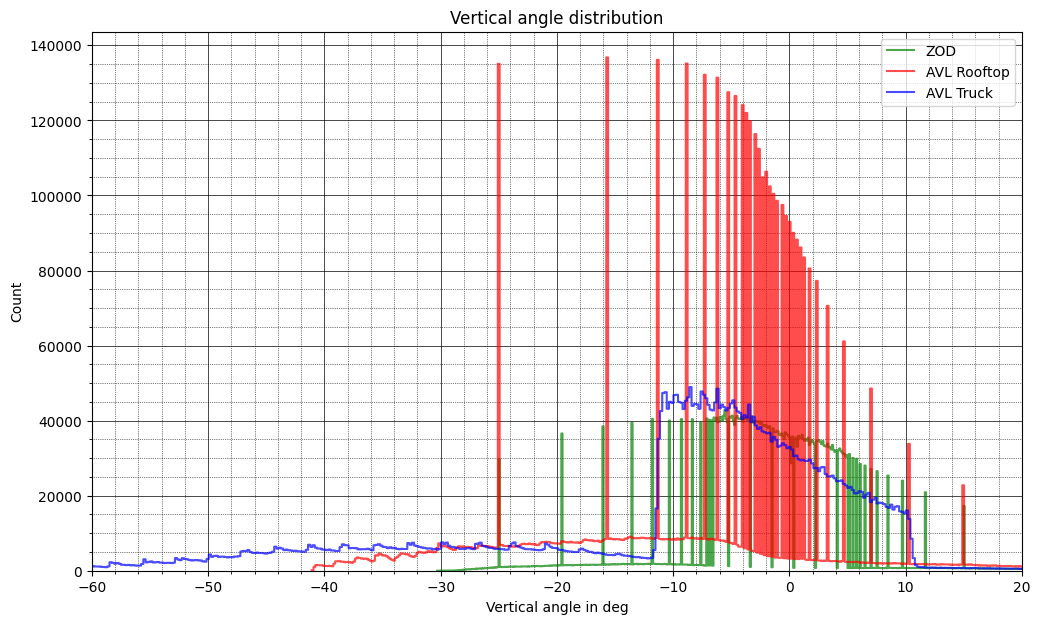

In [34]:
#print vertical angle dist
lidar_heights = [2.08702246, 1.7715138, 3.4097]
fig, ax = plt.subplots(1,1, figsize=(12,7))
#x_limits = [-20,40]
for i, pts in enumerate(points):
    #filter points within x_limits
    #pts = pts[np.logical_and(pts[:,0] > x_limits[0], pts[:,0] < x_limits[1])]
    alphas = np.arctan2(pts[:,2] - lidar_heights[i], np.linalg.norm(pts[:,0:2], axis=1))
    alphas = np.rad2deg(alphas)
    #sns.distplot(alphas, ax=ax, color=colors[i], hist=False,  kde_kws={"shade": True, "bw_adjust":0.01}, label=labels[i])
    sns.histplot(alphas, ax=ax, color=colors[i], label=labels[i], bins=600, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", alpha=0.7, stat="count")

#ax.set_xlim(x_limits)
ax.set_title("Vertical angle distribution")
ax.set_xlabel("Vertical angle in deg")
ax.legend()
ax.set_axisbelow(True)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.set_xlim([-60,20])
plt.show()